In [1]:
%matplotlib inline

from datetime import datetime
from imp import reload

import attr
import gym
from matplotlib import pyplot as plt
import numpy as np
from numpy.random import seed as rng_seed
# from smooth import smooth

ENV_NAME = 'CartPole-v1'
env = gym.make(ENV_NAME)
STATE_SIZE = env.observation_space.shape
ACTION_SIZE = env.action_space.n
ACTOR_STEP_SIZE = .01
CRITIC_STEP_SIZE = .01
DISCOUNT_RATE = 0.99


# https://machinelearningmastery.com/reproducible-results-neural-networks-keras/#comment-414394
rng_seed(0)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# REINFORCE Monte-Carlo PG episodic
### From Sutton/Barto Reinforcement Learning 2nd ed, p. 330

- Uses linear linear value function approximation in the CartPole env.

State function is: $$f(x, {\dot{x}}, {\theta}, {\dot{\theta}}) \hspace{2pt} {\rightarrow} \hspace{2pt} (1, x, {\dot{x}}, {\theta}, {\dot{\theta}}, x{\dot{x}}, {\theta}{\dot{\theta}}, x{\theta}, x{\dot{\theta}}, {\dot{x}}{\theta}, {\dot{x}}{\dot{\theta}}, x{\dot{x}}{\theta}{\dot{\theta}})$$

In [2]:
import attr
import gym
from matplotlib import pyplot as plt
import numpy as np

env_name = 'CartPole-v1'
env = gym.make(env_name)


def cartpole_state_func(state):
    # for cartpole: pos, vel, ang, ang vel
    pos, vel, ang, ang_vel = state
    return np.array([1, pos, vel, ang, ang_vel, pos*vel, ang*ang_vel, pos*ang, pos*ang_vel, vel*ang, vel*ang_vel, pos*vel*ang*ang_vel])


@attr.s
class Policy:
    weights = attr.ib()
    state_func = attr.ib()

    def get_action(self, state):
        if np.random.random() < self.weights.dot(self.state_func(state)):
            return 1
        return 0


def run_episode(policy, env, render=False):
    state = env.reset()
    is_done = False
    states, actions, rewards = [], [], []
    for _ in range(200):                
        if render:
            env.render()        
        action = policy.get_action(state)
        state_, reward, is_done, _ = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        state = state_
        if is_done:
            break
    return states, actions, rewards


def discounted_return(rewards, discount=0.95):
    total = 0
    for idx, score in enumerate(rewards):
        total += (discount ** idx) * score
    return total


def reinforce(policy, env, step_size_start=5e-6, step_size_end=1e-7, discount=0.9, num_episodes=2000, render_every=50):
    training_rewards = []
    step_sizes = []
    best_return = float('-inf')
    best_weights = None
    step_size = step_size_start
    step_size_change = (step_size_start - step_size_end) / num_episodes
    for episode in range(num_episodes):
        
        states, actions, rewards = run_episode(policy, env, render=episode % render_every == 0)
        episode_return = sum(rewards)        
        if episode_return > best_return:
            best_return = episode_return
            best_weights = policy.weights
        training_rewards.append(episode_return)  
        step_size = step_size_end + step_size_start * .995 ** episode
        step_sizes.append(step_size)
        for idx, action in enumerate(actions):
            state = states[idx]
            G = discounted_return(rewards[idx:])            
            if episode % render_every == 0:
                print(f'{episode}: {episode_return}, step-size: {step_size:.2}', end='\r', flush=True)
            policy.weights += step_size * G * policy.state_func(state)/policy.weights.dot(policy.state_func(state))
    return training_rewards, best_return, best_weights, step_sizes



policy = Policy(weights=np.random.random(12), state_func=cartpole_state_func)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


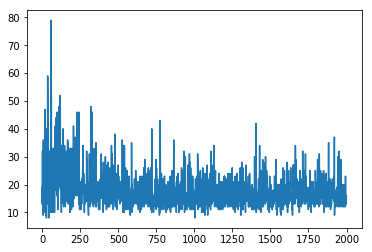

In [3]:
step_size_start = 5e-6
step_size_end = 1e-12
num_episodes = 2000
training_rewards, best_return, best_weights, step_sizes = reinforce(policy, env, render_every=50, num_episodes=num_episodes, step_size_start=step_size_start, step_size_end=step_size_end)
plt.plot(training_rewards)
plt.show()
env.close()


Overall performance is really poor, but occasionally it manages to find an okay set of weights, eg:

In [4]:

best_return, best_weights

(79.0, array([0.84195908, 0.72629281, 0.63635925, 0.53133389, 0.35589013,
        0.64759963, 0.44342972, 0.89042133, 0.95981982, 0.38186492,
        0.80422408, 0.52904229]))

In [8]:
policy.weights = np.array([-0.95455163,  0.13930325, -6.69851751,  0.61900001, 10.44033207,
         0.42629127,  0.1821342 ,  0.10251606,  0.38757577,  0.17812744,
        -0.23087766,  0.67571064])
env.reset()
for idx in range(10):
    run_episode(policy, env, render=True)


### Reinforce w. Baseline & gradient MCmethod for Value func approximation, see pp 202 & 331

In [24]:
@attr.s
class ValueFunc:
    func = attr.ib()
    
    def __attrs_post_init__(self):
        self.weights = np.random.random(12)
        
    def predict(self, state):
        data = self.state_func(state)
        return self.weights.dot(data)
    
    def state_func(self, state):
        return self.func(state)
    
    
def reinforce_with_baseline(policy, value_func, env, policy_step_size, value_func_step_size, discount=0.95, num_episodes=2000, render_every=50):
    value_func_gradient_sizes = []
    scores = []
    for episode in range(num_episodes):
        states, actions, rewards = run_episode(policy, env, render=episode % render_every == 0)
        scores.append(sum(rewards))
        for idx, reward in enumerate(rewards):
            discounted_total_rewards = discounted_return(rewards[idx:], discount=discount)
            state = states[idx]
            td_delta = discounted_total_rewards - value_func.predict(state)
            value_func_gradient = value_func.state_func(state)
            value_func_gradient_sizes.append(value_func_gradient.dot(value_func_gradient))
            discount_factor = discount ** idx * td_delta
            value_func.weights += value_func_step_size * discount_factor * value_func_gradient
            policy.weights += policy_step_size * discount_factor * policy.state_func(state)/policy.weights.dot(policy.state_func(state))
        print(f'Episode: {episode}, total discounted reward: {discounted_total_rewards}', end='\r', flush=True)
    return value_func_gradient_sizes, scores

policy2 = Policy(weights=np.random.random(12), state_func=cartpole_state_func)
value_func = ValueFunc(func=cartpole_state_func)
value_func_gradient_sizes, scores = reinforce_with_baseline(
    policy2, 
    value_func,
    env,
    policy_step_size=2e-9,
    value_func_step_size=.005,
)

In [23]:
# Use Sutton/Barto heuristic to set value function step size: 0.1 / Expectation of the squared mag of the gradient.
grad_sizes = np.array(value_func_gradient_sizes)
0.1 / (grad_sizes.dot(grad_sizes)/len(value_func_gradient_sizes))

0.007198140171450216

Pol step size: 1e-14, value function step size target: 0.009070239465483056


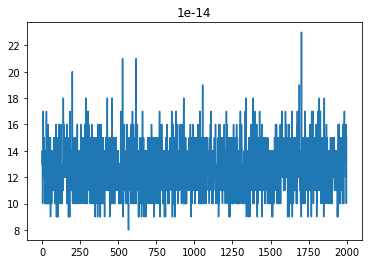

Pol step size: 1e-12, value function step size target: 0.008771108915198821


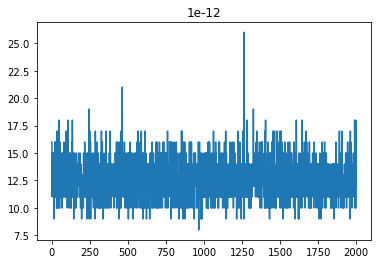

Pol step size: 1e-10, value function step size target: 0.00878405653422344


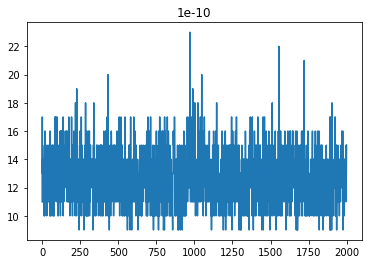

Pol step size: 1e-08, value function step size target: 0.008882831995224102


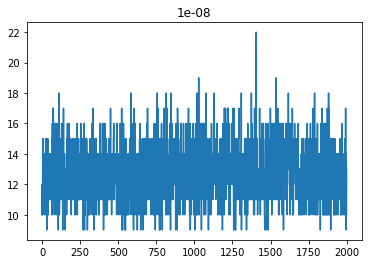

Pol step size: 1e-06, value function step size target: 0.00932966992936466


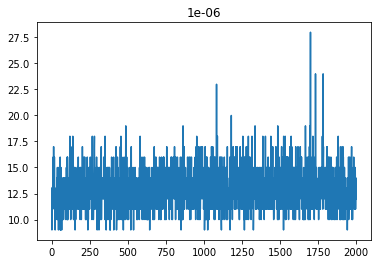

Pol step size: 0.0001, value function step size target: 0.0006322541651729955


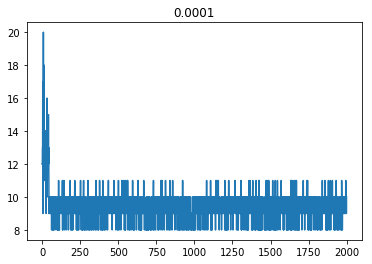

In [27]:
for policy_step_size in [1e-14, 1e-12, 1e-10, 1e-8, 1e-6, 1e-4]:
    value_func_gradient_sizes, scores = reinforce_with_baseline(
        policy2, 
        value_func,
        env,
        policy_step_size=policy_step_size,
        value_func_step_size=.005,
    )
    grad_sizes = np.array(value_func_gradient_sizes)
    valu_func_target = 0.1 / (grad_sizes.dot(grad_sizes)/len(value_func_gradient_sizes))
    print(f'Pol step size: {policy_step_size}, value function step size target: {valu_func_target}')
    plt.plot(scores)
    plt.title(f'{policy_step_size}')
    plt.show()